# Fitting Gaussian Mixture Models with EM

In this assignment you will
* implement the EM algorithm for a Gaussian mixture model
* apply your implementation to cluster images
* explore clustering results and interpret the output of the EM algorithm  

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

In [33]:
from google.colab import drive
drive.mount('/content/drive')

## Import necessary packages

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

### Try the model on simulated data

To visually comprehend how the EM model will work, we will generate some observations from a mixture of Gaussians and then run our EM algorithm to discover the mixture components. We'll begin with a function to generate the data, and a quick plot to visualize its output for a 2-dimensional mixture of three Gaussians.

Now we will create a function to generate data from a mixture of Gaussians model. 

In [35]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

After specifying a particular set of clusters (so that the results are reproducible across assignments), we use the above function to generate a dataset.

In [36]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

In [37]:
data

[array([0.31845368, 5.03182099]),
 array([1.45029339, 2.15717573]),
 array([1.02645431, 4.76042375]),
 array([ 5.23493625, -0.81138851]),
 array([ 4.65710743, -0.08532351]),
 array([0.43746553, 4.93778385]),
 array([-0.12756373,  5.14296293]),
 array([4.18200738, 0.24819247]),
 array([ 1.65646672, -0.87991369]),
 array([-0.69508006,  5.03848976]),
 array([6.01348014, 1.87722666]),
 array([ 0.20099208, -0.93213203]),
 array([-0.38268222,  0.26365374]),
 array([ 5.03394554, -1.66740986]),
 array([ 1.53889119, -0.12731715]),
 array([0.81448617, 1.63543709]),
 array([1.7219243 , 0.28460715]),
 array([4.90757786, 0.56716088]),
 array([0.60512066, 4.87555125]),
 array([ 1.30867865, -0.58711045]),
 array([0.19570654, 5.73836612]),
 array([3.97078181, 0.39328234]),
 array([0.47190777, 1.47637309]),
 array([1.32157017, 0.56486368]),
 array([3.89988459, 0.92433204]),
 array([0.11205488, 6.4072012 ]),
 array([0.40717315, 1.67134485]),
 array([0.56231532, 5.01349864]),
 array([1.82113515, 0.788922

Now plot the data you created above. The plot should be a scatterplot with 100 points that appear to roughly fall into three clusters.

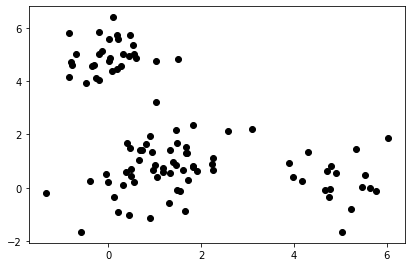

In [38]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

**EM Algorithm**

In [39]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [40]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                # YOUR CODE HERE
                resp[j, k] = weights[k] * multivariate_normal.pdf(data[j], means[k], covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            # YOUR CODE HERE
            weights[k] = counts[k]/num_data
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            weighted_sum = 0
            for j in range(num_data):
                # YOUR CODE HERE
                weighted_sum += resp[j,k]*data[j]
            # YOUR CODE HERE
            means[k] = weighted_sum/counts[k]
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                # YOUR CODE HERE (Hint: Use np.outer on the data[j] and this cluster's mean)
                weighted_sum += resp[j,k] * np.outer(data[j] - means[k], data[j] - means[k])
            # YOUR CODE HERE
            covariances[k] = weighted_sum/counts[k]
          
        
        # Compute the loglikelihood at this iteration
        # YOUR CODE HERE
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [41]:
np.random.seed(5)

# Run EM 
results = EM(data, init_means, init_covariances, init_weights)

In [42]:
results['weights']

[0.17993705211224312, 0.5193474609075368, 0.30071548698022005]

In [43]:
results['means']

[array([4.94239271, 0.31365279]),
 array([1.08181198, 0.73900991]),
 array([0.02140055, 4.94769902])]

In [44]:
results['covs']

[array([[ 0.35564328, -0.01494828],
        [-0.01494828,  0.66694997]]), array([[0.67115722, 0.33059425],
        [0.33059425, 0.90424313]]), array([[0.29327424, 0.05045345],
        [0.05045345, 0.35286118]])]

In [45]:
results['resp']

array([[8.58352306e-21, 2.40414528e-07, 9.99999760e-01],
       [6.43721705e-09, 9.99999802e-01, 1.92035234e-07],
       [1.20725964e-15, 8.23363364e-05, 9.99917664e-01],
       [9.99999998e-01, 2.43077670e-09, 7.11552968e-48],
       [9.99997958e-01, 2.04207907e-06, 1.59861568e-37],
       [8.37934919e-20, 8.17112791e-07, 9.99999183e-01],
       [9.99433022e-24, 1.38110503e-08, 9.99999986e-01],
       [9.99774619e-01, 2.25380510e-04, 3.07550456e-31],
       [4.97552776e-07, 9.99999502e-01, 6.09719053e-25],
       [1.07615025e-26, 2.70173956e-09, 9.99999997e-01],
       [9.99999694e-01, 3.06415653e-07, 6.23135992e-36],
       [9.84557894e-15, 1.00000000e+00, 5.84100558e-22],
       [1.18572807e-17, 1.00000000e+00, 1.89551923e-13],
       [9.99999999e-01, 9.39489336e-10, 7.62019191e-53],
       [8.57531709e-08, 9.99999914e-01, 7.62921603e-20],
       [1.58423417e-11, 9.99999970e-01, 3.04133508e-08],
       [4.62785010e-07, 9.99999537e-01, 6.36825778e-18],
       [9.99997778e-01, 2.22164

In [46]:
results['loglik']

[-330.6328950993575,
 -318.8647253140341,
 -318.83469786745917,
 -318.8311639708876,
 -318.83084785625636,
 -318.8308229018945]

Now we'll fit a mixture of Gaussians to this data using our implementation of the EM algorithm. As with k-means, it is important to ask how we obtain an initial configuration of mixing weights and component parameters. In this simple case, we'll take three random points to be the initial cluster means, use the empirical covariance of the data to be the initial covariance in each cluster (a clear overestimate), and set the initial mixing weights to be uniform across clusters.

For sklearn's model, there is no internal customization to output values, but fortunately we can still listen to its log through `sys.stdout` stream. **Enable `verbose=50` to save the model running course to a buffer.**

In [47]:
# redirect the log print into a buffer
import io, sys
log_buffer = io.StringIO()
default_stdout = sys.stdout
sys.stdout = log_buffer

# Create the model using Sklearn's library. Make sure to set verbosity to level 50
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=len(init_weights), random_state=5, verbose=50, means_init=init_means, weights_init=init_weights, precisions_init=np.linalg.inv(init_covariances))
model.fit(data)
# results = EM(data, initial_means, initial_covs, initial_weights)

sys.stdout = default_stdout
log_buffer.seek(0)
print(log_buffer.read())

**Note**. Like k-means, EM is prone to converging to a local optimum. In practice, you may want to run EM multiple times with different random initialization. We have omitted multiple restarts to keep the assignment reasonably short. For the purpose of this assignment, we assign a particular random seed (`random_state=5`) to ensure consistent results among the students.

We can extract related information from the fitted model in variable `model`. Specific parameters can be found <a href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html">here</a>.

*For the following quiz questions, please round your answer to the nearest thousandth (3 decimals)*

**Quiz Question**: What is the weight that EM assigns to the first component after running the above codeblock?

In [48]:
model.weights_

array([0.17993446, 0.51920795, 0.30085759])

**Quiz Question**: Using the same set of results, obtain the mean that EM assigns the second component. What is the mean in the first dimension?

In [49]:
model.means_

array([[4.94241209, 0.313636  ],
       [1.08183786, 0.73833182],
       [0.02187836, 4.9468878 ]])

**Quiz Question**: Using the same set of results, obtain the covariance that EM assigns the third component. What is the variance in the first dimension?

In [50]:
model.covariances_

array([[[ 0.35562019, -0.01492245],
        [-0.01492245,  0.66693537]],

       [[ 0.67136971,  0.33072254],
        [ 0.33072254,  0.90278528]],

       [[ 0.29362123,  0.04961264],
        [ 0.04961264,  0.35410133]]])

### Plot progress of parameters

One useful feature of testing our implementation on low-dimensional simulated data is that we can easily visualize the results. 

We will use the following `plot_contours` function to visualize the Gaussian components over the data at three different points in the algorithm's execution:

1. At initialization (using initial_mu, initial_cov, and initial_weights)
2. After running the algorithm to completion 
3. After just 12 iterations (using parameters estimates returned when setting `maxiter=12`)

In [51]:
import matplotlib.mlab as mlab

# provided function to display bivariate normal contours
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                     mux=0.0, muy=0.0, sigmaxy=0.0):

    
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denominator = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denominator


def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

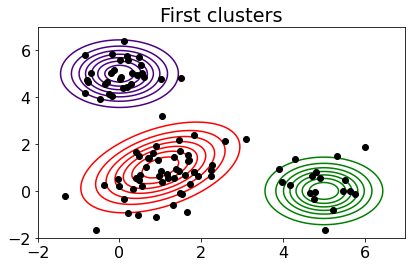

In [52]:
plot_contours(data, init_means, init_covariances, 'First clusters')

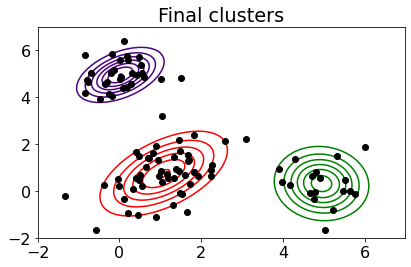

In [53]:
# Parameters after running EM to convergence
plot_contours(data, model.means_, model.covariances_, 'Final clusters')

**Quiz Question**: Plot the loglikelihood that is observed at each iteration. Is the loglikelihood plot monotonically increasing, monotonically decreasing, or neither [multiple choice]? 

In [54]:
# extract the log likelihood from the buffer
log_buffer.seek(0)
buffered_text = log_buffer.read()
# YOUR CODE HERE
loglikelihoods = results['loglik']

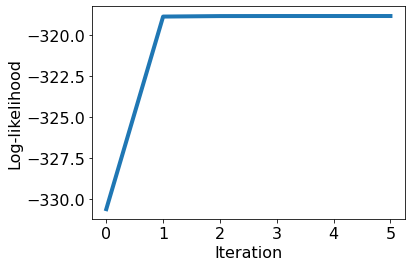

In [55]:
plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Fitting a Gaussian mixture model for image data

Now that we're confident in our implementation of the EM algorithm, we'll apply it to cluster some more interesting data. In particular, we have a set of images that come from four categories: sunsets, rivers, trees and forests, and cloudy skies. For each image we are given the average intensity of its red, green, and blue pixels, so we have a 3-dimensional representation of our data. Our goal is to find a good clustering of these images using our EM implementation; ideally our algorithm would find clusters that roughly correspond to the four image categories.

To begin with, we'll take a look at the data and get it in a form suitable for input to our algorithm. The data are provided in a folder and organized as needed:

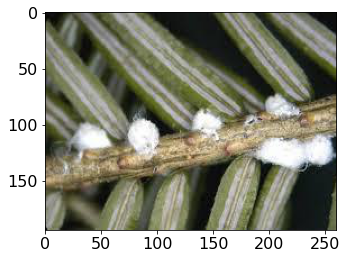

In [56]:
import os
from matplotlib.image import imread
image_location = "/content/drive/MyDrive/FUNIX Progress/MLP304x_0.1-A_EN/Lab 4/images"
for root, _, files in sorted(os.walk(image_location)):
    for f in sorted(files):
        print("File {:s} located in {:s}".format(f, root))
        #pass

# Show the last file read in the location
last_file = os.path.join(root, f)
last_file_data = imread(last_file)
plt.imshow(last_file_data)
#print(last_file_data.shape)

Your challenge is to load the data into a `pandas.DataFrame` and convert the data into required format. The DataFrame <u>must</u> have two fields: *label* and *mean*. The label should be provided by the parent folder, and the mean is the average values of R/G/B loaded in from `matplotlib.image.imread`.

In [57]:
import matplotlib as mlp
import matplotlib.pyplot as plt

In [58]:
data = []

In [59]:
image_location = "/content/drive/MyDrive/FUNIX Progress/MLP304x_0.1-A_EN/Lab 4/images"
for root, _, files in sorted(os.walk(image_location)):
    for f in sorted(files):
        data.append([root.replace(image_location + '/', ''), mlp.image.imread(root + '/' + f)])

In [60]:
data = pd.DataFrame(data, columns=['label', 'raw_image'])

In [61]:
data.head()

,label,raw_image
0,cloudy_sky,"[[[118, 127, 132], [113, 122, 127], [110, 119,..."
1,cloudy_sky,"[[[27, 71, 136], [28, 72, 137], [28, 72, 137],..."
2,cloudy_sky,"[[[20, 33, 75], [20, 33, 75], [20, 33, 75], [2..."
3,cloudy_sky,"[[[67, 75, 78], [67, 75, 78], [69, 77, 80], [7..."
4,cloudy_sky,"[[[197, 199, 194], [196, 198, 193], [195, 197,..."


In [62]:
data['mean'] = data['raw_image']
for i in range(data.shape[0]):
  data['mean'][i] = np.mean(data['raw_image'][i][0], axis=0)

In [63]:
# Read data from the selected directory and land it into DataFrame
data.head()

,label,raw_image,mean
0,cloudy_sky,"[[[118, 127, 132], [113, 122, 127], [110, 119,...","[153.2907488986784, 158.7092511013216, 160.440..."
1,cloudy_sky,"[[[27, 71, 136], [28, 72, 137], [28, 72, 137],...","[48.277992277992276, 93.42471042471043, 159.96..."
2,cloudy_sky,"[[[20, 33, 75], [20, 33, 75], [20, 33, 75], [2...","[44.81443298969072, 66.91237113402062, 125.015..."
3,cloudy_sky,"[[[67, 75, 78], [67, 75, 78], [69, 77, 80], [7...","[105.55212355212355, 110.74517374517374, 111.9..."
4,cloudy_sky,"[[[197, 199, 194], [196, 198, 193], [195, 197,...","[137.32818532818533, 141.75289575289574, 144.6..."


Similarly to another code block, you must set `verbose=50` or higher to listen to the model's log. Unlike the prior block, failing to put it in will stop you from completing the section **Evaluate convergence** below.

In [64]:
import sys, io
log_buffer = io.StringIO()
default_stdout = sys.stdout
sys.stdout = log_buffer
img_data = np.stack(list(data["mean"].values))
# don't forget verbose=50
img_model = GaussianMixture(n_components=4, random_state=5, verbose=50)
img_model.fit(img_data)

sys.stdout = default_stdout
log_buffer.seek(0)
print(log_buffer.read())

In [65]:
img_model.means_

array([[107.31600049,  96.97367076, 108.259917  ],
       [140.61021773, 144.33649694, 148.95181537],
       [ 84.18888047,  92.89791736,  65.47650095],
       [119.80980543, 145.12942696, 170.1272082 ]])

The following sections will evaluate the results by asking the following questions:

* **Convergence**: How did the log likelihood change across iterations? Did the algorithm achieve convergence?
* **Uncertainty**: How did cluster assignment and uncertainty evolve?
* **Interpretability**: Can we view some example images from each cluster? Do these clusters correspond to known image categories?

### Evaluating convergence

Let's start by plotting the log likelihood at each iteration - we know that the EM algorithm guarantees that the log likelihood can only increase (or stay the same) after each iteration, so if our implementation is correct then we should see an increasing function.

In [66]:
# Nitty gritty details that aren't that useful. Used to extract the log likelihood changes from verbose output.
log_buffer.seek(0)
log = log_buffer.read().strip().split("\n")[:-1]
#print(log[-2].split("ll"))
final_ll = float(log[-1].split("ll")[-1].split()[-1].strip())
# ignore first line and first change (inf)
changes = [float(l.split("ll change")[-1].strip()) for l in log[1:-1]]
current_ll = final_ll
backward_ll = []
for c in changes[::-1]:
    current_ll = current_ll - c
    backward_ll.append(current_ll)
ll = backward_ll[::-1] + [final_ll]

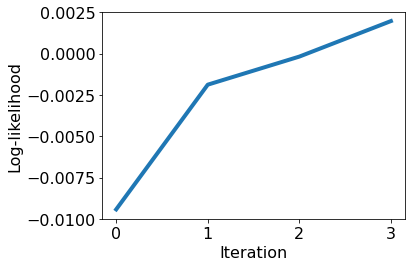

In [67]:
#ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

The log likelihood increases so quickly on the first few iterations that we can barely see the plotted line. Let's plot the log likelihood after the first three iterations to get a clearer view of what's going on:

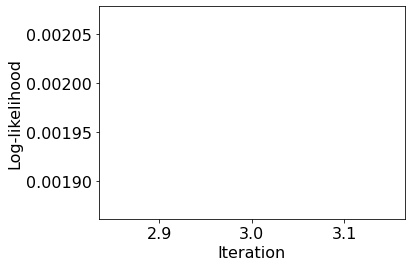

In [68]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Evaluating uncertainty

Next we'll explore the evolution of cluster assignment and uncertainty. Remember that the EM algorithm represents uncertainty about the cluster assignment of each data point through the responsibility matrix. Rather than making a 'hard' assignment of each data point to a single cluster, the algorithm computes the responsibility of each cluster for each data point, where the responsibility corresponds to our certainty that the observation came from that cluster. 

We can track the evolution of the responsibilities across iterations to see how these 'soft' cluster assignments change as the algorithm fits the Gaussian mixture model to the data; one good way to do this is to plot the data and color each point according to its cluster responsibilities. Our data are three-dimensional, which can make visualization difficult, so to make things easier we will plot the data using only two dimensions, taking just the [R G], [G B] or [R B] values instead of the full [R G B] measurement for each observation.

**Note: this code is using image loaded from imshow as-is, which is in BGR. Modify it if you have formatted to a different form such as RGB.**

In [69]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    # imgread values is actually BGR
    B, G, R = *img.T,
    #R = img['red']
    #B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

To begin, we will visualize what happens when each data has random responsibilities.

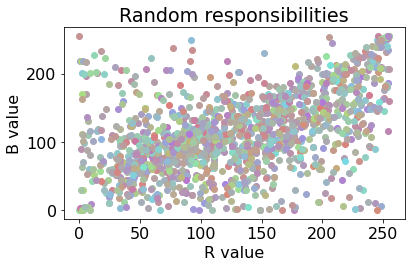

In [70]:
responsibilities = img_model.predict_proba(img_data)
N, K = responsibilities.shape #out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(img_data, random_resp, 'Random responsibilities')

We now use the above plotting function to visualize the responsibilities in the last iteration. We will see there are fewer unique colors; this indicates that there is more certainty that each point belongs to one of the four components in the model. 

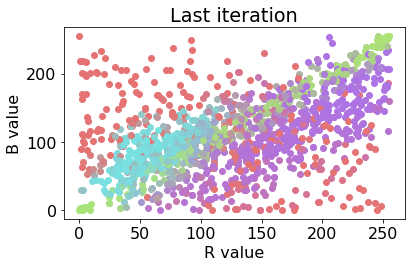

In [71]:
#out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(img_data, responsibilities, 'Last iteration')

Plotting the responsibilities over time in [R B] space shows a meaningful change in cluster assignments over the course of the algorithm's execution. While the clusters look significantly better organized at the end of the algorithm than they did at the start, it appears from our plot that they are still not very well separated. We note that this is due in part our decision to plot 3D data in a 2D space; everything that was separated along the G axis is now "squashed" down onto the flat [R B] plane. If we were to plot the data in full [R G B] space, then we would expect to see further separation of the final clusters.  We'll explore the cluster interpretability more in the next section.

### Interpreting each cluster

Let's dig into the clusters obtained from our EM implementation. Recall that our goal in this section is to cluster images based on their RGB values. We can evaluate the quality of our clustering by taking a look at a few images that 'belong' to each cluster. We hope to find that the clusters discovered by our EM algorithm correspond to different image categories - in this case, we know that our images came from four categories ('cloudy sky', 'rivers', 'sunsets', and 'trees and forests'), so we would expect to find that each component of our fitted mixture model roughly corresponds to one of these categories.

If we want to examine some example images from each cluster, we first need to consider how we can determine cluster assignments of the images from our algorithm output. This was easy with k-means - every data point had a 'hard' assignment to a single cluster, and all we had to do was find the cluster center closest to the data point of interest. Here, our clusters are described by probability distributions (specifically, Gaussians) rather than single points, and our model maintains some uncertainty about the cluster assignment of each observation.

One way to phrase the question of cluster assignment for mixture models is as follows: how do we calculate the distance of a point from a distribution? Note that simple Euclidean distance might not be appropriate since (non-scaled) Euclidean distance doesn't take direction into account.  For example, if a Gaussian mixture component is very stretched in one direction but narrow in another, then a data point one unit away along the 'stretched' dimension has much higher probability (and so would be thought of as closer) than a data point one unit away along the 'narrow' dimension. 

In fact, the correct distance metric to use in this case is known as [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance). For a Gaussian distribution, this distance is proportional to the square root of the negative log likelihood. This makes sense intuitively - reducing the Mahalanobis distance of an observation from a cluster is equivalent to increasing that observation's probability according to the Gaussian that is used to represent the cluster. This also means that we can find the cluster assignment of an observation by taking the Gaussian component for which that observation scores highest. We'll use this fact to find the top examples that are 'closest' to each cluster.

Now we calculate cluster assignments for the entire image dataset using the result of running EM above:

In [72]:
responsibilities = img_model.predict_proba(img_data)
assignments = np.argmax(responsibilities, axis=-1)
probs = np.max(responsibilities, axis=-1)
    
clustered_images = pd.DataFrame({"assignments" : assignments, "probs": probs, "image": data["raw_image"]})

We'll use the `clustered_images` DataFrame to find the top images from each cluster by sorting the datapoints within each cluster by their score under that cluster (stored in `probs`). We can plot the corresponding images in the original data using show().

Create a function that returns the top 5 images assigned to a given category in our data (HINT: use DataFrame's `.nlargest` to find the k top values according to specified column).

In [73]:
def get_top_images(clustered_images, cluster_idx, k=5):
    # YOUR CODE HERE
    cluster = ["cloudy_sky", "rivers", "sunsets", "trees_and_forest"]
    select_cluster = clustered_images[clustered_images['assignments'] == cluster[cluster_idx]]
    top_images = select_cluster.nlargest(k, 'probs')
    return top_images['image']

Use this function to show the top 5 images in each cluster.

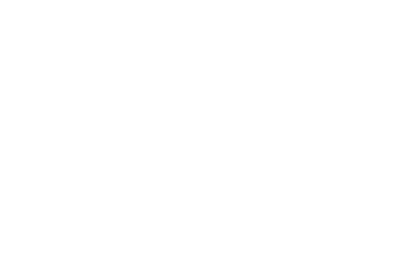

In [75]:
# images are plotted in 
fig, axes = plt.subplots(2 * 2, 3 * 2, sharex="col", sharey="row")
for component_id in range(0, 4):
    offset_x, offset_y = (component_id % 2, component_id // 2)
    images = get_top_images(clustered_images, component_id, k=5)
    for i, img in enumerate(images):
        img_offset_x, img_offset_y = i % 2, i // 2
        ax = axes[2*offset_x + img_offset_x, 3*offset_y + img_offset_y]
        ax.imshow(img)
[ax.axis("off") for subaxes in axes for ax in subaxes]
#fig.tight_layout()
pass

These look pretty good! Our algorithm seems to have done a good job overall at 'discovering' the four categories that from which our image data was drawn. It seems to have had the most difficulty in distinguishing between rivers and cloudy skies, probably due to the similar color profiles of images in these categories; if we wanted to achieve better performance on distinguishing between these categories, we might need a richer representation of our data than simply the average [R G B] values for each image.

__Quiz Question:__ Which of the following images are *not* in the list of top 5 images in the first cluster?